In [33]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import plot_tree
import shap
import warnings
import os
warnings.filterwarnings('ignore')

# Set styling for plots
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.grid(True)

sns.set_palette("viridis")


In [34]:
def load_and_prepare_data(train_path: str, test_path: str) -> tuple:
    """Load and preprocess solar irradiance data for machine learning pipelines.
    
    Processes training and test sets separately to prevent data leakage while
    maintaining consistent feature engineering across both datasets.
    
    Parameters:
        train_path (str): Path to training data CSV file
        test_path (str): Path to test data CSV file
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test) - Prepared feature matrices and target vectors
    
    Processing Steps:
        1. Data loading with pandas
        2. Missing value imputation using linear interpolation
        3. Target variable separation
        4. Feature selection based on domain knowledge
        5. Feature alignment between train/test sets
        6. Data quality reporting
    """
    # Load raw datasets with pandas
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)

    # Temporal interpolation for time-series data (assumes sorted timestamps)
    train_data = train_data.interpolate(method='linear', axis=0)
    test_data = test_data.interpolate(method='linear', axis=0)

    # Target variable definition (Global Horizontal Irradiance)
    target = "GlobalHorizontalIrradiance(GHI)(W/m²)"

    # Initial feature/target separation
    X_train = train_data.drop(target, axis=1)
    y_train = train_data[target]
    X_test = test_data.drop(target, axis=1)
    y_test = test_data[target]

    # Feature selection rationale:
    # - Remove redundant irradiance measurements (DNI/DIF highly correlated with GHI)
    # - Temporal features (minute/month) excluded for simplified baseline model
    cols_to_drop = [
        'DirectNormalIrradiance(DNI)(W/m²)',
        'DiffuseHorizontalIrradiance(DIF)(W/m²)',
        'minute',
        'month'
    ]

    X_train = X_train.drop(cols_to_drop, axis=1, errors='ignore')
    X_test = X_test.drop(cols_to_drop, axis=1, errors='ignore')

    # Ensure feature parity between datasets to prevent dimension mismatch
    common_features = list(set(X_train.columns) & set(X_test.columns))
    X_train = X_train[common_features]
    X_test = X_test[common_features]

    # Data quality report (helps identify potential preprocessing issues)
    print("===== Data Quality Summary =====")
    print(f"Training dataset shape: {train_data.shape}")
    print(f"Test dataset shape: {test_data.shape}")

    print("\nTarget variable statistics (Train):")
    print(f"- Min: {y_train.min():.2f} W/m²")
    print(f"- Max: {y_train.max():.2f} W/m²")
    print(f"- Mean: {y_train.mean():.2f} W/m²")
    print(f"- Std Dev: {y_train.std():.2f} W/m²")

    print("\nTarget variable statistics (Test):")
    print(f"- Min: {y_test.min():.2f} W/m²")
    print(f"- Max: {y_test.max():.2f} W/m²")
    print(f"- Mean: {y_test.mean():.2f} W/m²")
    print(f"- Std Dev: {y_test.std():.2f} W/m²")

    return X_train, X_test, y_train, y_test


In [35]:
def train_evaluate_model(
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series
) -> tuple:
    """Train and evaluate XGBoost regression model with comprehensive validation.
    
    Implements full ML pipeline including:
    - Feature scaling with standardization
    - Hyperparameter tuning using grid search
    - Cross-validation
    - Test set evaluation
    - Baseline model comparison
    
    Parameters:
        X_train (DataFrame): Training feature matrix
        X_test (DataFrame): Test feature matrix
        y_train (Series): Training target values (GHI measurements)
        y_test (Series): Test target values (GHI measurements)
        
    Returns:
        tuple: (best_model, X_train_scaled, X_test_scaled, y_pred)
            - Best trained XGBoost model
            - Scaled training features
            - Scaled test features 
            - Test set predictions
    
    Key Considerations:
        - Strict train/test separation to prevent data leakage
        - Scalers fitted only on training data
        - Nested cross-validation strategy
        - Baseline model for performance comparison
    """
    # Feature standardization - critical for regularized models
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit only on train
    X_test_scaled = scaler.transform(X_test)        # Transform test

    # Initialize XGBoost regressor with reproducibility
    model = xgb.XGBRegressor(
        objective='reg:squarederror',  # Standard regression objective
        random_state=42                # Seed for reproducibility
    )

    print("\n===== Hyperparameter Optimization =====")
    # Conservative grid for initial search (expand for full tuning)
    param_grid = {
    # Tree structure controls
    "max_depth": [6, 8, 10, 12],          # Deeper trees for complex patterns
    "learning_rate": [0.01, 0.05, 0.1],   # Wider range for rate/estimator tradeoff
    "n_estimators": [100, 200, 300],      # Vary with learning rate
    
    # Regularization parameters
    "reg_lambda": [1, 5, 10],            # L2 regularization range
    "reg_alpha": [0, 0.1, 0.5, 1]       # L1 regularization options
    }

    
    # Nested cross-validation setup
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=50,  # Budget for iterations
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1
    )

    # Execute hyperparameter search
    search.fit(X_train_scaled, y_train)
    best_params = search.best_params_
    print(f"Optimal parameters: {best_params}")

    # Train final model with best parameters
    best_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **best_params
    ).fit(X_train_scaled, y_train)  # Final fit on full training data

    # Test set evaluation metrics
    y_pred = best_model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("\n===== Final Model Evaluation =====")
    print(f"RMSE: {rmse:.3f} W/m² ({(rmse/y_test.max())*100:.2f}% of max)")
    print(f"MAE: {mae:.3f} W/m²")
    print(f"R²: {r2:.3f} (1.0 = perfect prediction)")

    # Additional validation with outer cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(
        best_model, X_train_scaled, y_train,
        cv=kf, scoring='neg_root_mean_squared_error'
    )
    print(f"\nCV RMSE: {-cv_scores.mean():.3f} ± {cv_scores.std():.3f} W/m²")

    # Baseline linear model comparison
    lr = LinearRegression().fit(X_train_scaled, y_train)
    y_pred_lr = lr.predict(X_test_scaled)
    print(f"\nBaseline Linear Model R²: {r2_score(y_test, y_pred_lr):.2f}")

    return best_model, X_train_scaled, X_test_scaled, y_pred


In [36]:
def analyze_model(
    model: xgb.XGBRegressor,
    X_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_train: pd.Series,
    y_test: pd.Series,
    y_pred: np.ndarray,
    X_train_scaled: np.ndarray,
    X_test_scaled: np.ndarray
) -> None:
    """Comprehensive model diagnostic analysis for solar irradiance prediction.
    
    Generates 4 key analysis reports:
    1. Feature Importance Analysis
    2. Error Distribution Analysis
    3. Learning Curve Analysis
    4. Model Performance Summary
    
    Parameters:
        model: Trained XGBoost regressor
        X_train: Raw training features
        X_test: Raw test features  
        y_train: Training target values (GHI)
        y_test: Test target values (GHI)
        y_pred: Model predictions on test set
        X_train_scaled: Scaled training features
        X_test_scaled: Scaled test features
        
    Saves:
        - feature_importance.png
        - error_analysis.png
        - learning_curve.png
    """

    feature_names = X_train.columns

    # ===== 1. Feature Importance Analysis =====
    plt.figure(figsize=(15, 10))

    # 1a. XGBoost Native Importance (Gain-based)
    plt.subplot(2, 2, 1)
    xgb.plot_importance(model, max_num_features=10, height=0.5, ax=plt.gca())
    plt.title("Gain-based Feature Importance (XGBoost)")

    # 1b. SHAP Values (Unified Feature Impact)
    plt.subplot(2, 2, 2)
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer(X_test_scaled, check_additivity=False)

        # Calculate mean absolute SHAP values
        feature_importance = np.abs(shap_values.values).mean(0)
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importance
        }).sort_values('Importance', ascending=False)

        # Visualize top 10 features
        top_features = feature_importance_df.head(10)
        plt.barh(np.arange(len(top_features)), top_features['Importance'])
        plt.yticks(np.arange(len(top_features)), top_features['Feature'])
        plt.title("SHAP Value Impact Analysis")

        # 1c. Cumulative Importance Analysis
        plt.subplot(2, 2, 3)
        sorted_idx = np.argsort(feature_importance)[::-1]
        sorted_importance = feature_importance[sorted_idx]
        cumulative_importance = np.cumsum(
            sorted_importance) / sorted_importance.sum()

        plt.plot(range(1, len(sorted_importance)+1),
                 cumulative_importance, 'o-')
        plt.axhline(0.95, color='r', linestyle='--', label='95% Threshold')
        plt.axhline(0.99, color='g', linestyle='--', label='99% Threshold')
        plt.xlabel('Number of Features')
        plt.ylabel('Cumulative Explanatory Power')
        plt.title('Feature Contribution Progression')
        plt.legend()

        # 1d. Feature Importance Summary
        features_95 = np.argmax(cumulative_importance >= 0.95) + 1
        features_99 = np.argmax(cumulative_importance >= 0.99) + 1

    except Exception as e:
        print(f"SHAP analysis failed: {str(e)}")
        features_95 = features_99 = 0
        feature_importance_df = pd.DataFrame()

    # Summary panel
    plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.text(0.1, 0.9, "Feature Efficiency Summary:", fontweight='bold')
    plt.text(0.1, 0.8, f"95% variance explained by {features_95} features")
    plt.text(0.1, 0.7, f"99% variance explained by {features_99} features")

    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ===== 2. Error Analysis =====
    plt.figure(figsize=(15, 10))
    errors = y_test - y_pred

    # 2a. Actual vs Predicted Values
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5, color='#3498db')
    lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(lims, lims, 'r--', linewidth=1)
    plt.title("GHI Prediction Accuracy")
    plt.xlabel("Measured GHI (W/m²)")
    plt.ylabel("Predicted GHI (W/m²)")

    # 2b. Error Distribution
    plt.subplot(2, 2, 2)
    sns.histplot(errors, kde=True, bins=30, color='#2ecc71')
    plt.axvline(0, color='r', linestyle='--')
    plt.title("Prediction Error Distribution")
    plt.xlabel("Prediction Error (W/m²)")

    # 2c. Residual Analysis
    plt.subplot(2, 2, 3)
    plt.scatter(y_pred, errors, alpha=0.5, color='#e74c3c')
    plt.axhline(0, color='r', linestyle='--')
    plt.title("Residual Pattern Analysis")
    plt.xlabel("Predicted GHI (W/m²)")
    plt.ylabel("Residuals (W/m²)")

    # 2d. Error Statistics
    plt.subplot(2, 2, 4)
    plt.axis('off')
    error_stats = [
        ("Mean Error", errors.mean()),
        ("Error STD", errors.std()),
        ("Median Error", np.median(errors)),
        ("RMSE", np.sqrt(mean_squared_error(y_test, y_pred))),
        ("MAE", mean_absolute_error(y_test, y_pred))
    ]
    plt.text(0.1, 0.9, "Error Profile:", fontweight='bold')
    for i, (name, val) in enumerate(error_stats):
        plt.text(0.1, 0.8-(i*0.1), f"{name}: {val:.3f} W/m²")

    plt.tight_layout()
    plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ===== 3. Learning Capacity Analysis =====
    plt.figure(figsize=(10, 6))

    # Calculate learning curve metrics
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train_scaled, y_train,
        cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_root_mean_squared_error'
    )

    # Transform scores for visualization
    train_mean = -np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = -np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Create learning curve plot
    plt.plot(train_sizes, train_mean, 'o-', color='#3498db', label='Training')
    plt.plot(train_sizes, test_mean, 'o-', color='#e74c3c', label='Validation')
    plt.fill_between(train_sizes, train_mean-train_std,
                     train_mean+train_std, alpha=0.1, color='#3498db')
    plt.fill_between(train_sizes, test_mean-test_std,
                     test_mean+test_std, alpha=0.1, color='#e74c3c')
    plt.xlabel('Training Dataset Size')
    plt.ylabel('RMSE (W/m²)')
    plt.title('Model Learning Capacity')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.savefig('learning_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ===== 4. Comprehensive Performance Report =====
    print("\n===== SOLAR IRRADIANCE MODEL DIAGNOSTICS =====")

    # Feature importance summary
    if not feature_importance_df.empty:
        print("\n[Feature Impact Analysis]")
        print("Top 5 Predictive Features:")
        for i, row in feature_importance_df.head(5).iterrows():
            print(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}")

        print(f"\nFeature Efficiency:")
        print(f"- {features_95} features explain 95% of variance")
        print(f"- {features_99} features explain 99% of variance")

    # Feature correlation analysis
    print("\n[Feature-Target Relationships]")
    corr_df = X_train.corrwith(y_train).abs().sort_values(ascending=False)
    print("Top 5 Correlated Features:")
    print(corr_df.head(5).to_string(header=False))

    # Model performance demonstration
    print("\n[Performance Across Irradiance Ranges]")
    ranges = [
        (0, 10),        # Night/Low-light
        (50, 150),      # Morning/Evening
        (200, 300),     # Moderate irradiance
        (400, 600),     # High irradiance
        (700, 1000)     # Peak conditions
    ]
    samples = []
    for r in ranges:
        try:
            idx = y_test[y_test.between(*r)].index[0]
            samples.append({
                'Actual': y_test[idx],
                'Predicted': y_pred[idx],
                'Error': y_test[idx] - y_pred[idx]
            })
        except IndexError:
            continue

    print(pd.DataFrame(samples).to_string(index=False))

    # Final metrics report
    print("\n[Quantitative Performance Metrics]")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f} W/m²")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} W/m²")
    print(f"R² Score: {r2_score(y_test, y_pred):.2f}")


In [37]:
def plot_regression_proof(
    y_test: pd.Series,
    y_pred: np.ndarray,
    save_path: str = 'regression_proof.png'
) -> None:
    """Generate comprehensive diagnostic plot for regression model validation.
    
    Creates a multi-component visualization containing:
    - Primary scatter plot with regression line
    - 95% prediction intervals
    - Density visualization subplot
    - Key regression metrics
    - Statistical significance indicators

    Parameters:
        y_test: Actual target values (GHI measurements)
        y_pred: Model predictions 
        save_path: Path to save output visualization

    Produces:
        PNG file with regression diagnostic plot
    """

    from scipy import stats
    import statsmodels.api as sm
    from matplotlib.patches import Patch

    # Initialize figure with professional styling
    plt.figure(figsize=(12, 10))
    ax = plt.subplot(111)  # Main plot axis

    # ===== 1. Primary Scatter Plot =====
    scatter = ax.scatter(
        y_test, y_pred,
        alpha=0.5,          # Transparency for density visualization
        edgecolor='k',      # Black borders for point distinction
        linewidth=0.5,
        zorder=3            # Ensure points appear above grid
    )

    # Set equal aspect ratio for proper visual interpretation
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    margin = (max_val - min_val) * 0.05  # 5% margin buffer
    ax.set_xlim(min_val - margin, max_val + margin)
    ax.set_ylim(min_val - margin, max_val + margin)

    # ===== 2. Reference Lines =====
    # Perfect prediction line (y=x)
    ax.plot([min_val - margin, max_val + margin],
            [min_val - margin, max_val + margin],
            'r--', linewidth=1.5, label='Ideal Prediction')

    # Linear regression best fit line
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        y_test, y_pred)
    x_line = np.linspace(min_val - margin, max_val + margin, 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'b-', linewidth=2,
            label=f'Best Fit: y = {slope:.3f}x + {intercept:.3f}')

    # ===== 3. Prediction Intervals =====
    try:
        # Use statsmodels for comprehensive interval calculation
        X = sm.add_constant(y_test)  # Add intercept term
        model = sm.OLS(y_pred, X).fit()  # Ordinary Least Squares regression

        # Calculate 95% prediction intervals
        pred_results = model.get_prediction(X).summary_frame(alpha=0.05)
        ax.fill_between(y_test, pred_results['obs_ci_lower'], pred_results['obs_ci_upper'],
                        color='gray', alpha=0.2, label='95% Prediction Interval')
    except Exception as e:
        print(f"Prediction interval calculation omitted: {str(e)}")

    # ===== 4. Metrics Annotation =====
    metrics = {
        'R²': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred),
        'Slope': slope,
        'Intercept': intercept,
        'p-value': p_value
    }

    textstr = '\n'.join([f'{k} = {v:.3f}' if isinstance(v, float)
                         else f'{k} = {v:.3g}' for k, v in metrics.items()])

    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # ===== 5. Density Subplot =====
    ax2 = plt.axes([0.65, 0.22, 0.2, 0.2])  # [left, bottom, width, height]

    # Calculate point density using Gaussian KDE
    xy = np.vstack([y_test, y_pred])
    z = gaussian_kde(xy)(xy)

    # Sort by density for visualization clarity
    idx = z.argsort()
    x_sorted, y_sorted, z_sorted = y_test.values[idx], y_pred[idx], z[idx]

    density_plot = ax2.scatter(x_sorted, y_sorted, c=z_sorted,
                               s=30, cmap='viridis')
    ax2.set_title('Observation Density Heatmap', fontsize=9)
    ax2.grid(True, alpha=0.3)

    # ===== 6. Final Styling =====
    ax.set_xlabel('Actual GHI (W/m²)', fontsize=14)
    ax.set_ylabel('Predicted GHI (W/m²)', fontsize=14)
    ax.set_title('Solar Irradiance Prediction Validation', fontsize=16, pad=20)
    ax.grid(True, alpha=0.3)
    ax.legend(loc='lower right', framealpha=0.9)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


In [38]:
def visualize_last_tree(model: xgb.XGBRegressor) -> None:
    """Visualize the final tree in an XGBoost ensemble for model interpretation.
    
    Provides insights into the terminal decision nodes of the boosting sequence,
    particularly useful for understanding residual patterns the last tree addresses.

    Parameters:
        model: Trained XGBoost regressor from train_evaluate_model()
        
    Outputs:
        - Interactive matplotlib visualization
        - PNG file (xgboost_tree.png) at 300 DPI
        - Console feedback about operation status

    Notes:
        - Requires graphviz installation (conda install graphviz)
        - Best used with model.booster.plot_tree() for interactive exploration
        - Recommended for models with < 1000 trees due to visual complexity
    """

    plt.figure(figsize=(30, 20))  # Large canvas for deep tree structures

    try:
        # Safely get tree count from booster interface
        n_trees = len(model.get_booster().get_dump())

        if n_trees == 0:
            raise ValueError("Model contains no trained trees")

        # Visualize final tree in the additive sequence
        tree_idx = n_trees - 1
        ax = xgb.plot_tree(model, num_trees=tree_idx)

        # Add professional styling
        plt.title(
            f"Final Regression Tree (Index {tree_idx}) - Solar Irradiance Prediction",
            fontsize=16,
            pad=20
        )
        plt.tight_layout()

        # Save publication-ready vector graphic
        plt.savefig("xgboost_tree.png", dpi=300, bbox_inches='tight')
        print(f"Tree {tree_idx} visualization saved to xgboost_tree.png")

        # Display interactive plot
        plt.show()

    except ValueError as ve:
        print(f"Visualization Error: {str(ve)}")
    except ImportError:
        print("Missing dependency: Install graphviz (conda install python-graphviz)")
    except Exception as e:
        print(f"Unexpected error during visualization: {str(e)}")


In [39]:
def main() -> None:
    """Solar Irradiance Prediction Pipeline
    
    Execution Workflow:
    1. Data Path Configuration
    2. Input Validation
    3. Data Preparation
    4. Model Training & Evaluation
    5. Model Diagnostics
    6. Decision Structure Visualization
    """

    # Configure data paths
    train_path = r"C:\Users\srikr\Desktop\Studies\Sem 4\Machine Learning\Project\Final\testing\15_min_solar_data_preprocessed.csv"
    test_path = r"C:\Users\srikr\Desktop\Studies\Sem 4\Machine Learning\Project\Final\testing\test_preprocessed.csv"

    # Validate input paths
    if not all(os.path.exists(p) for p in [train_path, test_path]):
        print("Error: Missing required data files")
        print(f"Train path exists: {os.path.exists(train_path)}")
        print(f"Test path exists: {os.path.exists(test_path)}")
        return

    try:
        # Data preparation phase
        X_train, X_test, y_train, y_test = load_and_prepare_data(
            train_path, test_path)

        # Model development phase
        model, X_train_scaled, X_test_scaled, y_pred = train_evaluate_model(
            X_train, X_test, y_train, y_test
        )

        # Diagnostic phase
        analyze_model(
            model=model,
            X_train=X_train,
            X_test=X_test,
            y_train=y_train,
            y_test=y_test,
            y_pred=y_pred,
            X_train_scaled=X_train_scaled,
            X_test_scaled=X_test_scaled
        )

        # Regression proof phase
        print("\n===== Regression Proof Visualization =====")
        plot_regression_proof(y_test, y_pred)

        # Model interpretation phase
        print("\n===== Model Structure Analysis =====")
        visualize_last_tree(model)

    except Exception as e:
        print(f"Pipeline failed: {str(e)}")
        print("Check data formats:\n- Ensure consistent columns\n- Verify no NaN values after preprocessing")


===== Data Quality Summary =====
Training dataset shape: (651552, 18)
Test dataset shape: (43872, 18)

Target variable statistics (Train):
- Min: 0.00 W/m²
- Max: 1048.00 W/m²
- Mean: 227.51 W/m²
- Std Dev: 313.45 W/m²

Target variable statistics (Test):
- Min: 0.00 W/m²
- Max: 1046.00 W/m²
- Mean: 229.64 W/m²
- Std Dev: 317.50 W/m²

===== Hyperparameter Optimization =====
Optimal parameters: {'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.05}

===== Final Model Evaluation =====
RMSE: 75.734 W/m² (7.24% of max)
MAE: 39.402 W/m²
R²: 0.943 (1.0 = perfect prediction)

CV RMSE: 73.724 ± 0.386 W/m²

Baseline Linear Model R²: 0.34


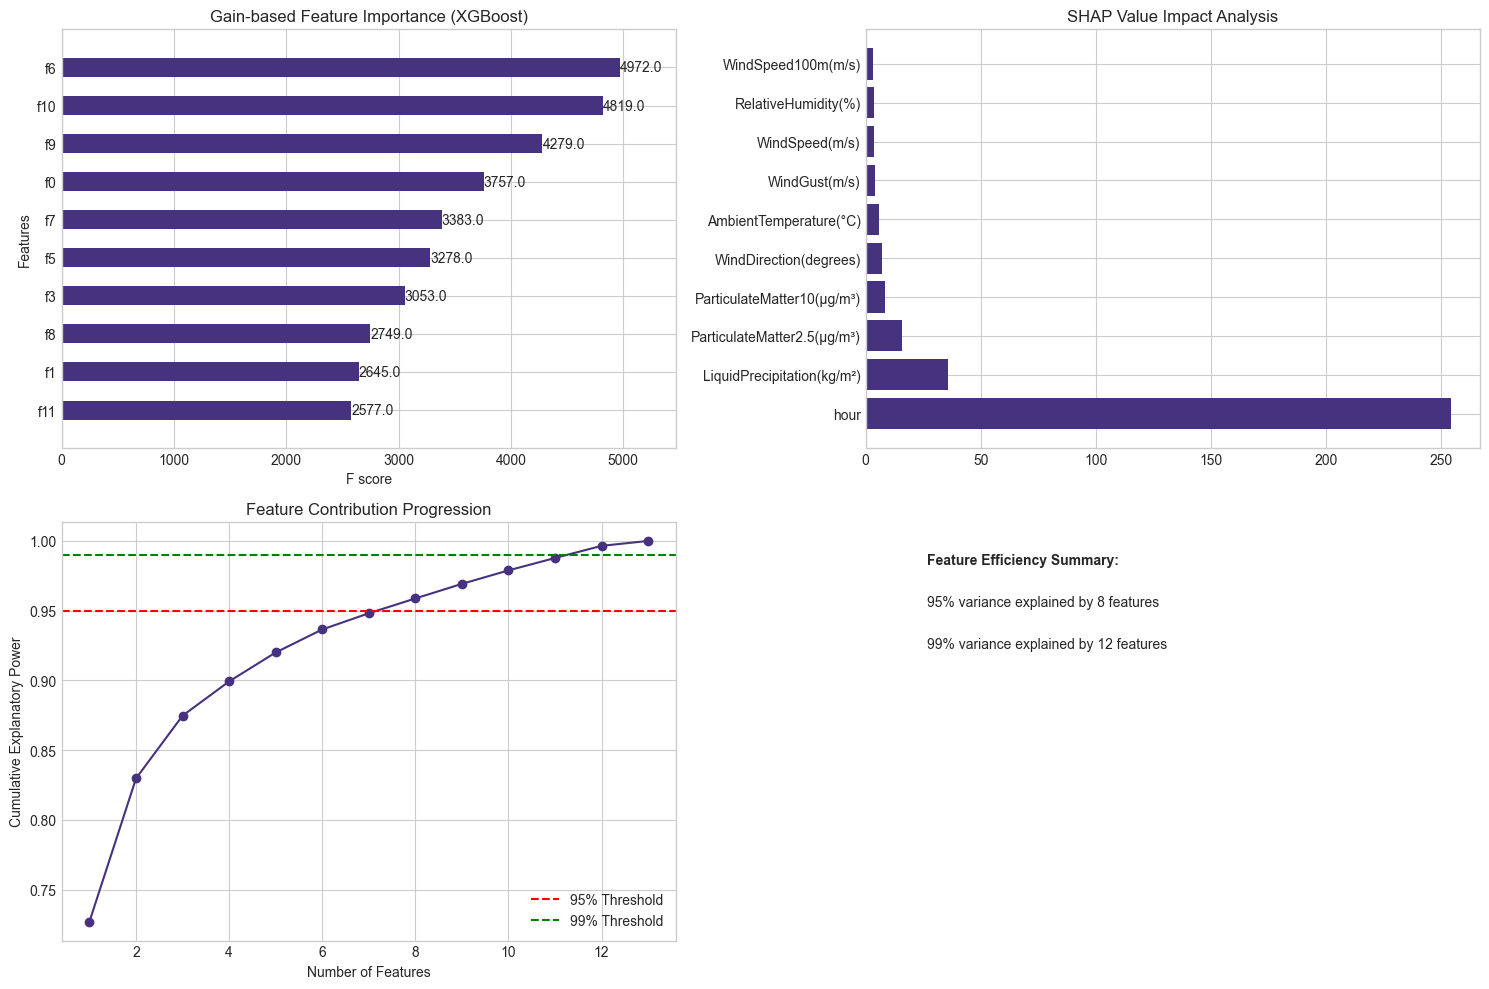

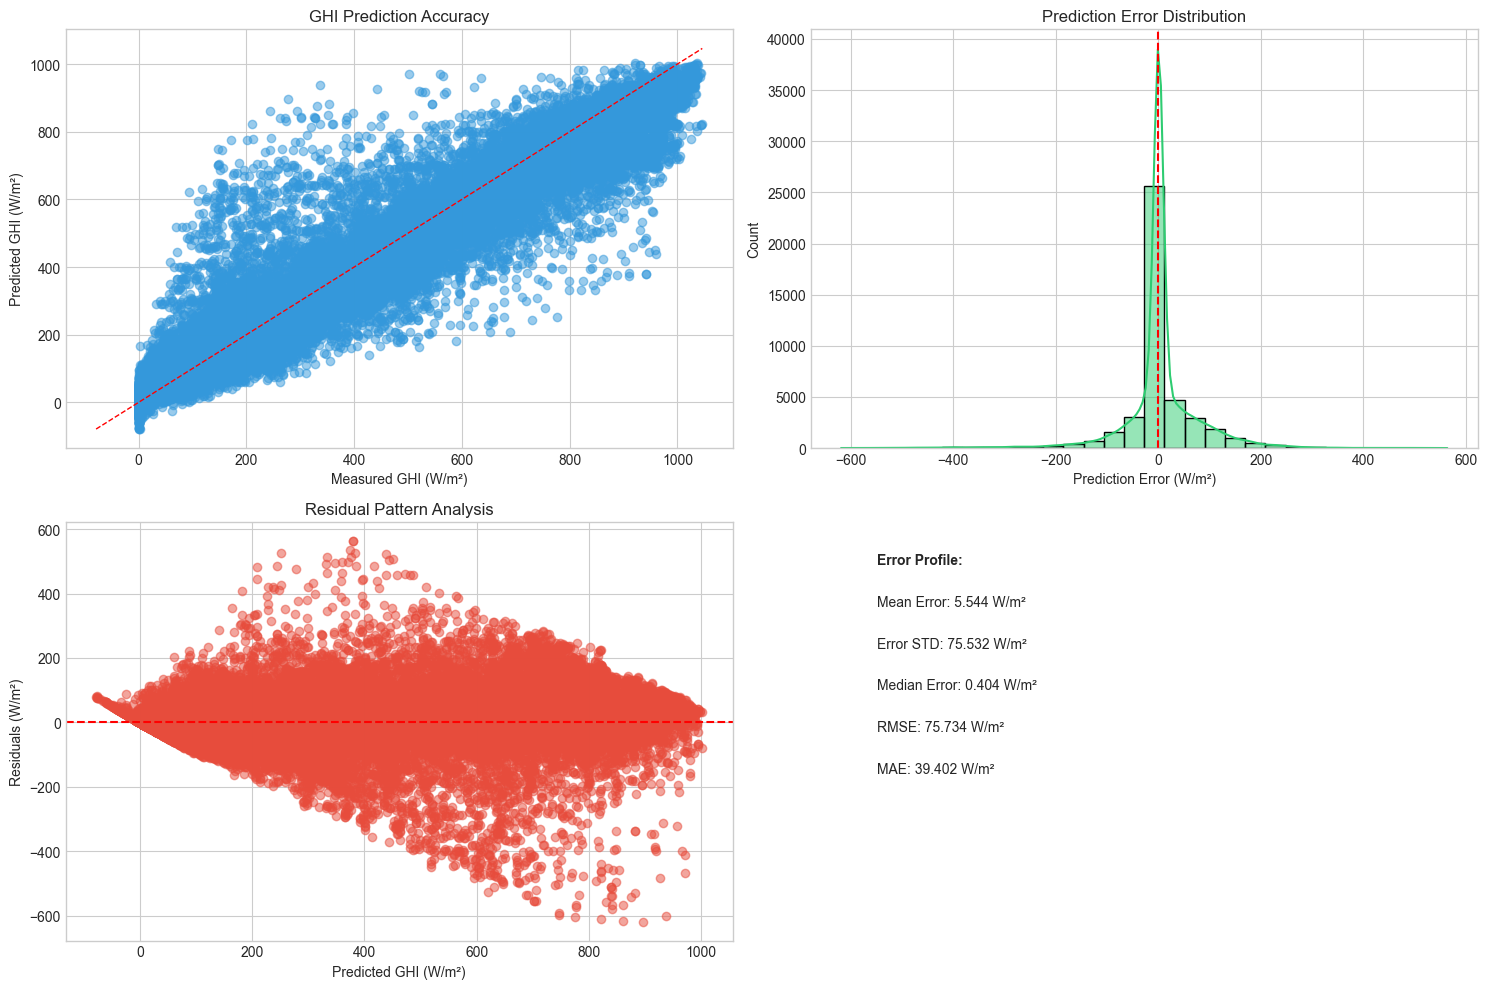

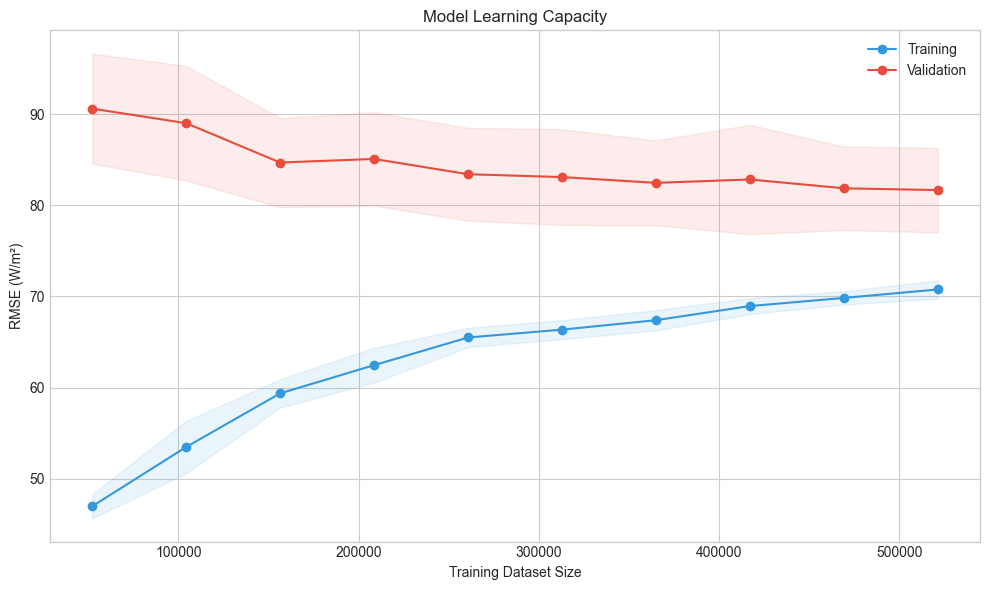


===== SOLAR IRRADIANCE MODEL DIAGNOSTICS =====

[Feature Impact Analysis]
Top 5 Predictive Features:
11. hour: 254.2080
8. LiquidPrecipitation(kg/m²): 35.8819
7. ParticulateMatter2.5(µg/m³): 15.7171
10. ParticulateMatter10(µg/m³): 8.5871
12. WindDirection(degrees): 7.2536

Feature Efficiency:
- 8 features explain 95% of variance
- 12 features explain 99% of variance

[Feature-Target Relationships]
Top 5 Correlated Features:
hour                           0.483624
RelativeHumidity(%)            0.261764
AmbientTemperature(°C)         0.192012
ParticulateMatter2.5(µg/m³)    0.170355
WindSpeed100m(m/s)             0.165498

[Performance Across Irradiance Ranges]
 Actual  Predicted      Error
      0   0.488813  -0.488813
     76  62.789810  13.210190
    224 256.931580 -32.931580
    438 436.949249   1.050751
    710 705.822327   4.177673

[Quantitative Performance Metrics]
RMSE: 75.73 W/m²
MAE: 39.40 W/m²
R² Score: 0.94

===== Regression Proof Visualization =====
Pipeline failed: name '

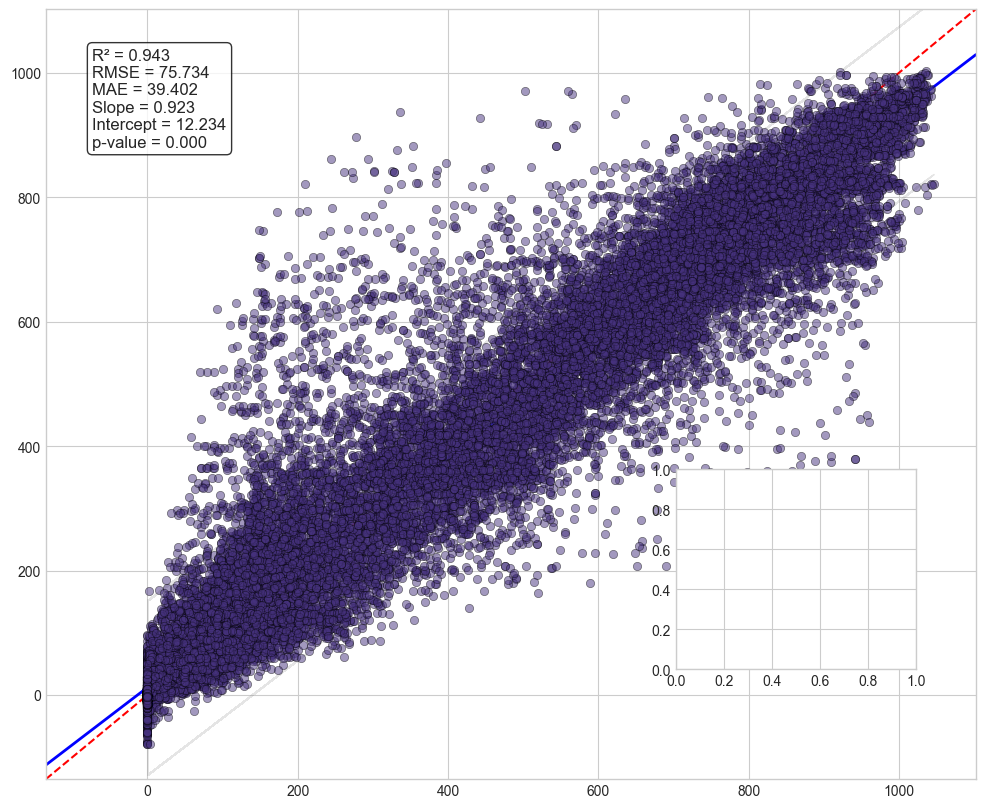

In [40]:
if __name__ == "__main__":
    main()
